In [26]:
import pyspark
from pyspark.sql import Window, functions as F

from kloppy.helpers import load_wyscout_event_data
from kloppy_spark import Pipeline, Source, Sink, utils
from kloppy_spark.stages import *
from kloppy_spark.sinks import *
from kloppy_spark.sources import *

from kloppy import datasets
from kloppy.domain import Dimension

from graphframes import GraphFrame

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Arc, Ellipse

In [27]:
#dataset = load_wyscout_event_data("wyscout_events.json")

dataset = datasets.load(
    "statsbomb", match_id=15946
)

In [29]:
ATTACKING_BOX = utils.Zone(x_dim=Dimension(88.5, 105), y_dim=Dimension(13.84, 54.16))


class FootballPitch(object):
    def __init__(
        self, xPitch=105.0, yPitch=68.0, grass_color="#a8bc95", line_color="#ffffff", orientation="horizontal"
    ):
        self.__grass_color = grass_color
        self.__line_color = line_color
        self.__show_10yd_marks = True
        self.__xPitch = xPitch
        self.__yPitch = yPitch
        self.__orientation = orientation

    @property
    def x_size(self):
        if self.__orientation == "horizontal":
            return self.__xPitch
        elif self.__orientation == "vertical":
            return self.__yPitch
        else:
            raise RuntimeError

    @property
    def y_size(self):
        if self.__orientation == "horizontal":
            return self.__yPitch
        elif self.__orientation == "vertical":
            return self.__xPitch
        else:
            raise RuntimeError

    @property
    def goal(self):
        return 7.32

    @property
    def box_height(self):
        if self.__orientation == "horizontal":
            return 40.3
        elif self.__orientation == "vertical":
            return 16.5
        else:
            raise RuntimeError

    @property
    def box_width(self):
        if self.__orientation == "horizontal":
            return 16.5
        elif self.__orientation == "vertical":
            return 40.3
        else:
            raise RuntimeError

    @property
    def goal_area_height(self):
        if self.__orientation == "horizontal":
            return 18.3
        elif self.__orientation == "vertical":
            return 5.5
        else:
            raise RuntimeError

    @property
    def goal_area_width(self):
        if self.__orientation == "horizontal":
            return 5.5
        elif self.__orientation == "vertical":
            return 18.3
        else:
            raise RuntimeError

    def draw_pitch(self, scale=1, fig=None, nrows=1, ncols=1, index=1):
        scale = 15 / scale
        if not fig:
            fig = plt.figure(figsize=(self.x_size / scale, self.y_size / scale))
            fig.patch.set_facecolor(self.__grass_color)

        axes = fig.add_subplot(nrows, ncols, index, facecolor=self.__grass_color, frameon=False)

        axes.xaxis.set_visible(False)
        axes.yaxis.set_visible(False)

        axes.set_xlim(0, self.x_size)
        axes.set_ylim(self.y_size, 0)

        axes = self._draw_patches(axes)

        return fig, axes

    def _draw_patches(self, axes):
        plt.xlim([-5, self.x_size + 5])
        plt.ylim([-5, self.y_size + 5])

        axes.add_patch(plt.Rectangle((0, 0), self.x_size, self.y_size, edgecolor=self.__line_color, facecolor="none"))

        #half-way line
        if self.__orientation == "horizontal":
            axes.add_line(
                plt.Line2D([self.x_size / 2, self.x_size / 2], [0, self.y_size], c=self.__line_color, linewidth=1)
            )
        elif self.__orientation == "vertical":
            axes.add_line(
                plt.Line2D([0, self.x_size], [self.y_size / 2, self.y_size / 2], c=self.__line_color, linewidth=1)
            )

        self._draw_penalty_areas(axes)
        self._draw_goals(axes)

        #halfway circle
        axes.add_patch(Ellipse((self.x_size / 2, self.y_size / 2), 9.15 * 2, 9.15 * 2, ec=self.__line_color, fc='none'))
        axes.add_patch(
            Ellipse((self.x_size / 2, self.y_size / 2), 0.5, 0.5, ec=self.__line_color, fc=self.__line_color)
        )

        self._draw_corners(axes)

        if self.__show_10yd_marks:
            self._draw_10yd_marks(axes)

        return axes

    def _draw_penalty_areas(self, axes):
        if self.__orientation == "horizontal":
            box1 = (0, (self.y_size / 2) - (self.box_height / 2))
            box2 = (self.x_size - self.box_width, (self.y_size / 2) - (self.box_height / 2))
            ga1 = (0, (self.y_size / 2) - (self.goal_area_height / 2))
            ga2 = (self.x_size - self.goal_area_width, (self.y_size / 2) - (self.goal_area_height / 2))
            p1 = (11, self.y_size / 2)
            p2 = (self.x_size - 11, self.y_size / 2)
            a = 90
        else:
            box1 = ((self.x_size / 2) - (self.box_width / 2), 0)
            box2 = ((self.x_size / 2) - (self.box_width / 2), self.y_size - self.box_height)
            ga1 = ((self.x_size / 2) - (self.goal_area_width / 2), 0)
            ga2 = ((self.x_size / 2) - (self.goal_area_width / 2), self.y_size - self.goal_area_height)
            p1 = (self.x_size / 2, 11)
            p2 = (self.x_size / 2, self.y_size - 11)
            a = 180

        #penalty areas
        axes.add_patch(plt.Rectangle(
            box1,
            self.box_width,
            self.box_height,
            ec=self.__line_color,
            fc='none',
        ))
        axes.add_patch(plt.Rectangle(
            box2,
            self.box_width,
            self.box_height,
            ec=self.__line_color,
            fc='none',
        ))

        #goal areas
        axes.add_patch(
            plt.Rectangle(
                ga1,
                self.goal_area_width,
                self.goal_area_height,
                ec=self.__line_color,
                fc='none',
            )
        )
        axes.add_patch(
            plt.Rectangle(
                ga2,
                self.goal_area_width,
                self.goal_area_height,
                ec=self.__line_color,
                fc='none',
            )
        )

        axes.add_patch(Arc(p1, 18.3, 18.3, angle=a - 90, theta1=-53, theta2=53, ec=self.__line_color, fc='none'))
        axes.add_patch(Arc(p2, 18.3, 18.3, angle=a + 90, theta1=-53.0, theta2=53, ec=self.__line_color, fc='none'))

        axes.add_patch(Ellipse(p1, 0.5, 0.5, ec=self.__line_color, fc=self.__line_color))
        axes.add_patch(Ellipse(p2, 0.5, 0.5, ec=self.__line_color, fc=self.__line_color))

    def _draw_goals(self, axes):
        if self.__orientation == "horizontal":
            axes.add_patch(
                plt.Rectangle(
                    (0, (self.y_size / 2) - (self.goal / 2)), -1.5, self.goal, ec=self.__line_color, fc='none'
                )
            )
            axes.add_patch(
                plt.Rectangle(
                    (self.x_size, (self.y_size / 2) - (self.goal / 2)), 1.5, self.goal, ec=self.__line_color, fc='none'
                )
            )
        elif self.__orientation == "vertical":
            axes.add_patch(
                plt.Rectangle(
                    ((self.x_size / 2) - (self.goal / 2), 0), self.goal, -1.5, ec=self.__line_color, fc='none'
                )
            )
            axes.add_patch(
                plt.Rectangle(
                    ((self.x_size / 2) - (self.goal / 2), self.y_size), self.goal, 1.5, ec=self.__line_color, fc='none'
                )
            )
        else:
            raise RuntimeError

    def _draw_corners(self, axes):
        axes.add_patch(Arc((0, 0), 2, 2, angle=0, theta1=0, theta2=90, ec=self.__line_color, fc='none'))
        axes.add_patch(Arc((0, self.y_size), 2, 2, angle=270, theta1=0, theta2=90, ec=self.__line_color, fc='none'))
        axes.add_patch(Arc((self.x_size, 0), 2, 2, angle=90, theta1=0, theta2=90, ec=self.__line_color, fc='none'))
        axes.add_patch(
            Arc((self.x_size, self.y_size), 2, 2, angle=180, theta1=0, theta2=90, ec=self.__line_color, fc='none')
        )

    def _draw_10yd_marks(self, axes):
        axes.add_line(plt.Line2D([-2, -1], [9.15, 9.15], c=self.__line_color, linewidth=1))
        axes.add_line(plt.Line2D([9.15, 9.15], [-2, -1], c=self.__line_color, linewidth=1))
        axes.add_line(plt.Line2D([-2, -1], [self.y_size - 9.15, self.y_size - 9.15], c=self.__line_color, linewidth=1))
        axes.add_line(plt.Line2D([9.15, 9.15], [self.y_size + 1, self.y_size + 2], c=self.__line_color, linewidth=1))
        axes.add_line(plt.Line2D([self.x_size - 9.15, self.x_size - 9.15], [-2, -1], c=self.__line_color, linewidth=1))
        axes.add_line(plt.Line2D([self.x_size + 1, self.x_size + 2], [9.15, 9.15], c=self.__line_color, linewidth=1))
        axes.add_line(
            plt.Line2D(
                [self.x_size + 1, self.x_size + 2], [self.y_size - 9.15, self.y_size - 9.15], c=self.__line_color,
                linewidth=1
            )
        )
        axes.add_line(
            plt.Line2D(
                [self.x_size - 9.15, self.x_size - 9.15], [self.y_size + 1, self.y_size + 2], c=self.__line_color,
                linewidth=1
            )
        )

    def arrows(self, xstart, ystart, xend, yend, *args, ax=None, **kwargs):
        if ax is None:
            raise TypeError("quiver() missing 1 required argument: ax. A matplotlib axis is required for plotting")

        units = kwargs.pop("units", "inches")
        scale_units = kwargs.pop("scale_units", "xy")
        angles = kwargs.pop("angles", "xy")
        scale = kwargs.pop("scale", 1)
        width = kwargs.pop("width", 4)
        width = width / 72.0

        xstart = np.ravel(xstart)
        ystart = np.ravel(ystart)
        xend = np.ravel(xend)
        yend = np.ravel(yend)

        if xstart.size != ystart.size:
            raise ValueError("xstart and ystart must be the same size")
        if xstart.size != xend.size:
            raise ValueError("xstart and xend must be the same size")
        if ystart.size != yend.size:
            raise ValueError("ystart and yend must be the same size")

        # vectors for direction
        u = xend - xstart
        v = yend - ystart

        if self.__orientation == "horizontal":
            q = ax.quiver(
                xstart, ystart, u, v, *args, units=units, scale_units=scale_units, angles=angles, scale=scale,
                width=width, **kwargs
            )
        elif self.__orientation == "vertical":
            q = ax.quiver(
                ystart, xstart, v, u, *args, units=units, scale_units=scale_units, angles=angles, scale=scale,
                width=width, **kwargs
            )
        else:
            raise RuntimeError

        #quiver_handler =
        return q


class PlotPasses(Sink):
    def process(self, pipeline: Pipeline, inputs: pyspark.sql.DataFrame) -> None:
        successful_passes = inputs.filter(inputs.result == "COMPLETE").collect()
        unsuccessful_passes = inputs.filter(inputs.result != "COMPLETE").collect()

        pitch = FootballPitch()
        fig, axes = pitch.draw_pitch(scale=2)

        def plot_passes(passes, pitch, ax, width=2, color="black"):
            x_start = [p.coordinates_x for p in passes]
            y_start = [p.coordinates_y for p in passes]
            x_end = [p.end_coordinates_x for p in passes]
            y_end = [p.end_coordinates_y for p in passes]
            pitch.arrows(x_start, y_start, x_end, y_end, ax=axes, width=width, color=color)

        plot_passes(successful_passes, pitch, axes)
        plot_passes(unsuccessful_passes, pitch, axes, width=1, color="red")

+---------+---------+-----+
|timestamp|period_id|score|
+---------+---------+-----+
| 2852.053|        2|  3:0|
| 2852.053|        2|  3:0|
| 2803.268|        2|  3:0|
|  2802.77|        2|  3:0|
| 2801.244|        2|  2:0|
| 2800.487|        2|  2:0|
| 2800.487|        2|  2:0|
| 2798.906|        2|  2:0|
| 2796.052|        2|  2:0|
| 2795.979|        2|  2:0|
| 2795.979|        2|  2:0|
| 2795.127|        2|  2:0|
| 2794.228|        2|  2:0|
| 2794.228|        2|  2:0|
| 2791.395|        2|  2:0|
| 2789.292|        2|  2:0|
| 2789.292|        2|  2:0|
| 2787.914|        2|  2:0|
| 2785.408|        2|  2:0|
| 2785.408|        2|  2:0|
+---------+---------+-----+
only showing top 20 rows

CPU times: user 281 ms, sys: 8.56 ms, total: 289 ms
Wall time: 3.32 s


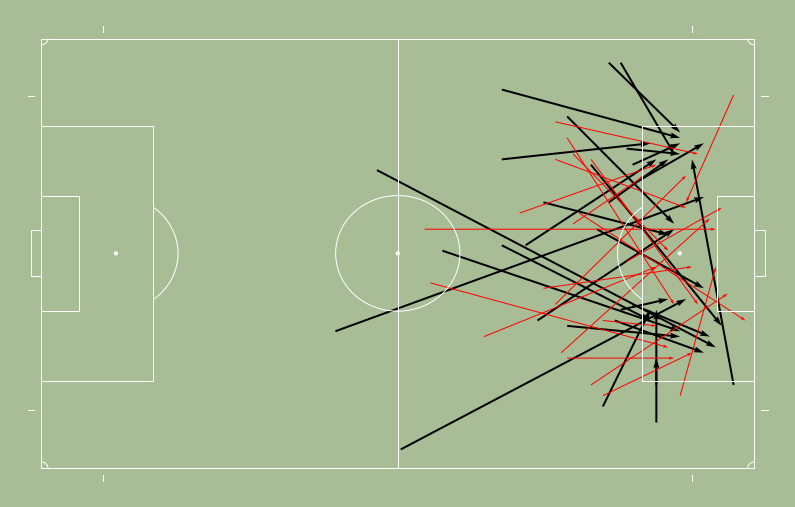

In [30]:
%%time

teams = list(dataset.metadata.teams)

# Create a Spark pipeline to load and pre-process a Kloppy Event DataSet
proc_pipe = Pipeline("kloppy::wyscout", sc) \
    & ("data", DatasetSource(dataset)) \
    | ("data", "transformed", CoordinateTransformer(
        from_dim=dataset.metadata.pitch_dimensions,
        to_dim=kp.PITCH_105_68))
    
# Calculate all passes of the home team into the ATTACKING_BOX
proc_pipe \
    | ("transformed", "passes", PassesIntoZone(ATTACKING_BOX, teams[0].team_id)) \
    | ("passes", "zone_pases_plot", PlotPasses())

# Calculate the score for each event
proc_pipe \
    | ("data", "score", Score(teams[0].team_id, teams[1].team_id)) \
    | ("score", "show_score", ShowDataFrame(["timestamp", "period_id", "score"], tail=True)) 

proc_pipe.run()

In [31]:
%%time


sequences = None
    
class Collect(Sink):
    def process(self, pipeline, inputs: pyspark.sql.DataFrame) -> None:
        global sequences
        sequences = inputs.collect()


# Create a Spark pipeline to load and pre-process a Kloppy Event DataSet
proc_pipe = Pipeline("kloppy::wyscout", sc) \
    & ("data", DatasetSource(dataset)) \
    | ("data", "transformed", CoordinateTransformer(
        from_dim=dataset.metadata.pitch_dimensions,
        to_dim=kp.PITCH_105_68)) \
    | ("transformed", "seq", Sequences()) \
    | ("seq", "debug", Collect())


proc_pipe.run()

print(len(sequences))

10
CPU times: user 279 ms, sys: 7.81 ms, total: 287 ms
Wall time: 1.52 s
